In [81]:
# ==== CELL 0: CONFIG & DEVICE ====
import os, torch

# Đường dẫn dữ liệu (đúng cấu trúc Train/Validate/Test như bạn dùng)
ROOT = r"C:/TRAIN/Deep Learning/vietnamese-foods/Images"
root_test = f"{ROOT}/Test"

IMG_SIZE = 224
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [82]:
# ==== CELL 1: TRANSFORMS GIỐNG LÚC TRAIN ====
from torchvision import transforms

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    # Nếu lúc train có Normalize(mean, std) thì PHẢI dùng y chang:
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225]),
])

In [83]:
# ==== CELL 2: HÀM BUILD + GỌI HÀM => TẠO test_loader, class_names ====
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def build_test_loader(root_test_dir, transform, batch_size):
    dataset = ImageFolder(root=root_test_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    class_names = list(dataset.classes)            # thứ tự theo thư mục của ImageFolder
    class_to_idx = dict(dataset.class_to_idx)      # mapping {class_name: idx} của dataset
    return loader, class_names, class_to_idx

# >>> GỌI HÀM (rất hay bị quên)
test_loader, class_names, ds_class_to_idx = build_test_loader(root_test, test_transform, BATCH_SIZE)

print("Số lớp:", len(class_names))
print("Ví dụ lớp:", class_names[:33])

Số lớp: 33
Ví dụ lớp: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo', 'banh_da_lon', 'banh_tieu', 'banh_trung_thu']


In [84]:
# ==== CELL 3: EVALUATION CORE – fixed label order & stable CM ====
import numpy as np, torch
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support

# 1) Chốt thứ tự nhãn (đã có class_names từ Cell 2)
assert "class_names" in globals(), "Bạn cần nạp class_names (thứ tự chuẩn) trước Cell 3!"
NUM_CLASSES = len(class_names)
name2idx = {n: i for i, n in enumerate(class_names)}

# 2) Tạo remap nếu dataset.class_to_idx không trùng thứ tự class_names
remap = None
if hasattr(test_loader.dataset, "class_to_idx"):
    ds_idx2name = {v: k for k, v in test_loader.dataset.class_to_idx.items()}
    # hoặc dùng ds_class_to_idx từ Cell 2:
    # ds_idx2name = {v: k for k, v in ds_class_to_idx.items()}
    remap = {src_idx: name2idx[ds_idx2name[src_idx]] for src_idx in range(len(ds_idx2name))}

def collect_logits(model, loader, device, remap=None):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            if remap is not None:
                y = torch.as_tensor([remap[int(t)] for t in y], dtype=torch.long)
            x = x.to(device)
            logits = model(x)
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            pred = prob.argmax(1)

            y_prob.append(prob)
            y_pred.append(pred)
            y_true.append(y.numpy())
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_prob)

# Sau Cell 3, bạn có thể dùng tiếp các cell đánh giá, vẽ CM, v.v.
print("OK: Core evaluation đã sẵn sàng.")

OK: Core evaluation đã sẵn sàng.


In [85]:
# QUICK CHECK trước khi vẽ
try:
    _ = iter(test_loader)
    assert len(class_names) > 0
    print("✅ test_loader & class_names sẵn sàng.")
except Exception as e:
    print("❌ Lỗi:", e)


✅ test_loader & class_names sẵn sàng.


In [86]:
# ==== CELL 4: PLOTS – CM & TOP CONFUSIONS ====
import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support

os.makedirs("images", exist_ok=True)

def plot_confusion(cm_counts, class_names, run_name, save_path, row_norm=True, threshold=0.10, dpi=300):
    """
    cm_counts: ma trận đếm (chưa chuẩn hoá) kích thước [C, C]
    row_norm : chuẩn hoá theo hàng (recall) để nhìn tỉ lệ đúng/sai từng lớp
    threshold: chỉ annotate các ô >= threshold (ngoài đường chéo) để đỡ rối
    """
    C = cm_counts.shape[0]
    cm = cm_counts.astype(float)
    if row_norm:
        cm = cm / cm.sum(axis=1, keepdims=True)
        cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(12, 10), dpi=200)
    sns.heatmap(cm, vmin=0, vmax=1, cmap="Blues", square=True,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': .6}, ax=ax)

    # annotate
    for i in range(C):
        for j in range(C):
            show = (i == j) or (cm[i, j] >= threshold)
            if show and cm_counts[i, j] > 0:
                ax.text(j + 0.5, i + 0.5,
                        f"{cm[i,j]*100:.0f}%\n({cm_counts[i,j]})",
                        ha="center", va="center", fontsize=7, color="black")

    ax.set_xlabel("Predicted", fontsize=12)
    ax.set_ylabel("True", fontsize=12)
    ax.set_title(f"Confusion Matrix (row-norm) – {run_name}", fontsize=14, pad=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()

def plot_top_confusions(cm_counts, class_names, run_name, save_path, topk=15, dpi=300):
    """
    Vẽ Top-K cặp dễ nhầm nhất (theo % hàng). Bỏ đường chéo.
    """
    cm = cm_counts.astype(float)
    cm = cm / cm.sum(axis=1, keepdims=True)
    cm = np.nan_to_num(cm)

    pairs = []
    C = cm.shape[0]
    for i in range(C):
        for j in range(C):
            if i == j: 
                continue
            if cm_counts[i, j] == 0:
                continue
            pairs.append((i, j, cm[i, j], cm_counts[i, j]))

    # sort theo tỷ lệ giảm dần
    pairs.sort(key=lambda x: x[2], reverse=True)
    pairs = pairs[:topk]

    if not pairs:
        print("Không có cặp nhầm đáng kể.")
        return

    labels = [f"{class_names[i]} → {class_names[j]}" for (i, j, _, _) in pairs]
    perc   = [100 * p for (_, _, p, _) in pairs]
    counts = [c for (_, _, _, c) in pairs]

    fig, ax = plt.subplots(figsize=(12, 7), dpi=200)
    ax.barh(labels, perc)
    ax.invert_yaxis()
    for k, (p, c) in enumerate(zip(perc, counts)):
        ax.text(p + 0.3, k, f"{p:.1f}% ({c})", va="center", fontsize=10)
    ax.set_xlabel("Tỉ lệ nhầm (%)")
    ax.set_title(f"Top-{len(pairs)} cặp dễ nhầm nhất – {run_name}", fontsize=14, pad=8)
    plt.tight_layout()
    plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    plt.show()


In [87]:
# ==== CELL 5: EVALUATE ONE RUN ====
import os, json, torch
import numpy as np

# Bạn có thể đổi để khớp folder thật của bạn
RUNS_DIR = "Runs"   # mỗi thư mục con là 1 lần train, có file .mtl/.pt/.pth

def model_auto(run_name: str, num_classes: int):
    """
    Chọn kiến trúc theo tên run. 
    - 'mobilenet'  -> timm mobilenetv4_conv_small
    - 'efficient'  -> timm efficientnet_b0
    - còn lại      -> mtl_cnn tự xây
    """
    name = run_name.lower()
    if "mobilenet" in name or "mnetv4" in name or "mobilenetv4" in name:
        import timm
        return timm.create_model("mobilenetv4_conv_small", pretrained=False, num_classes=num_classes).to(device)
    elif "efficient" in name or "b0" in name:
        import timm
        return timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)
    else:
        # mtl-cnn tự xây
        from model.mtl_cnn import mtl_cnn_v1
        return mtl_cnn_v1(num_classes=num_classes).to(device)




# --- REPLACE this in Cell 5 ---
from glob import glob
import os, time

EXTS = {".mtl", ".pt", ".pth"}

def find_checkpoint(run_path: str):
    """
    Tìm checkpoint trong run_path và các thư mục con phổ biến.
    Ưu tiên file có 'best' trong tên; nếu không có, lấy file mới nhất.
    """
    # các pattern hay gặp; ** để đảm bảo quét sâu
    patterns = [
        "*", "checkpoints/*", "checkpoint/*", "ckpt*/*",
        "models/*", "weights/*", "**/*"
    ]
    cands = []
    for pat in patterns:
        for p in glob(os.path.join(run_path, pat), recursive=True):
            if os.path.isfile(p) and os.path.splitext(p)[1].lower() in EXTS:
                cands.append(p)

    if not cands:
        return None

    # chấm điểm: có 'best' được +100, 'ema' +10, 'last' +5; sau đó ưu tiên mtime mới hơn
    def score(p):
        name = os.path.basename(p).lower()
        s = 0
        if "best" in name: s += 100
        if "ema"  in name: s += 10
        if "last" in name: s += 5
        return (s, os.path.getmtime(p))

    cands.sort(key=score, reverse=True)
    chosen = cands[0]
    print(f"  ✓ checkpoint: {os.path.relpath(chosen, run_path)}")
    return chosen



def load_checkpoint(model, ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    # cố gắng lấy state_dict trong nhiều key thường gặp
    state_dict = None
    for k in ["state_dict", "model", "net", "weights"]:
        if isinstance(state, dict) and k in state and isinstance(state[k], dict):
            state_dict = state[k]; break
    if state_dict is None:
        state_dict = state if isinstance(state, dict) else state.__dict__
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if missing:    print(f"  • Missing keys: {len(missing)} (chấp nhận nếu chỉ khác BN stats)")
    if unexpected: print(f"  • Unexpected keys: {len(unexpected)}")
    model.eval()
    return model

def evaluate_model_at(run_path: str, run_name: str):
    print(f"\n=== Đánh giá: {run_name} ===")
    ckpt = find_checkpoint(run_path)
    if not ckpt:
        print("  Không tìm thấy checkpoint (.mtl/.pt/.pth). Bỏ qua.")
        return None

    # Khởi tạo kiến trúc theo tên
    model = model_auto(run_name, num_classes=len(class_names))
    model = load_checkpoint(model, ckpt)

    # Thu logits
    y_true, y_pred, y_prob = collect_logits(model, test_loader, device, remap=remap)

    # Chỉ số tổng
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    print(f"   acc={acc:.4f}  precision={prec:.4f}  recall={rec:.4f}  f1={f1:.4f}")

    # Confusion matrix
    cm_counts = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plot_confusion(
        cm_counts, class_names, run_name,
        save_path=f"images/{run_name}_cm.png", row_norm=True, threshold=0.10, dpi=300
    )
    plot_top_confusions(
        cm_counts, class_names, run_name,
        save_path=f"images/{run_name}_topconf.png", topk=15, dpi=300
    )

    # trả kết quả để tổng hợp
    return {
        "run": run_name,
        "acc": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "n_images": int(len(y_true)),
        "ckpt": os.path.basename(ckpt),
    }



=== Đánh giá: mtl-cnn-20251029-201543 ===
  ✓ checkpoint: checkpoints\best.mtl


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\1403328210.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


   acc=0.4319  precision=0.4342  recall=0.4343  f1=0.4304


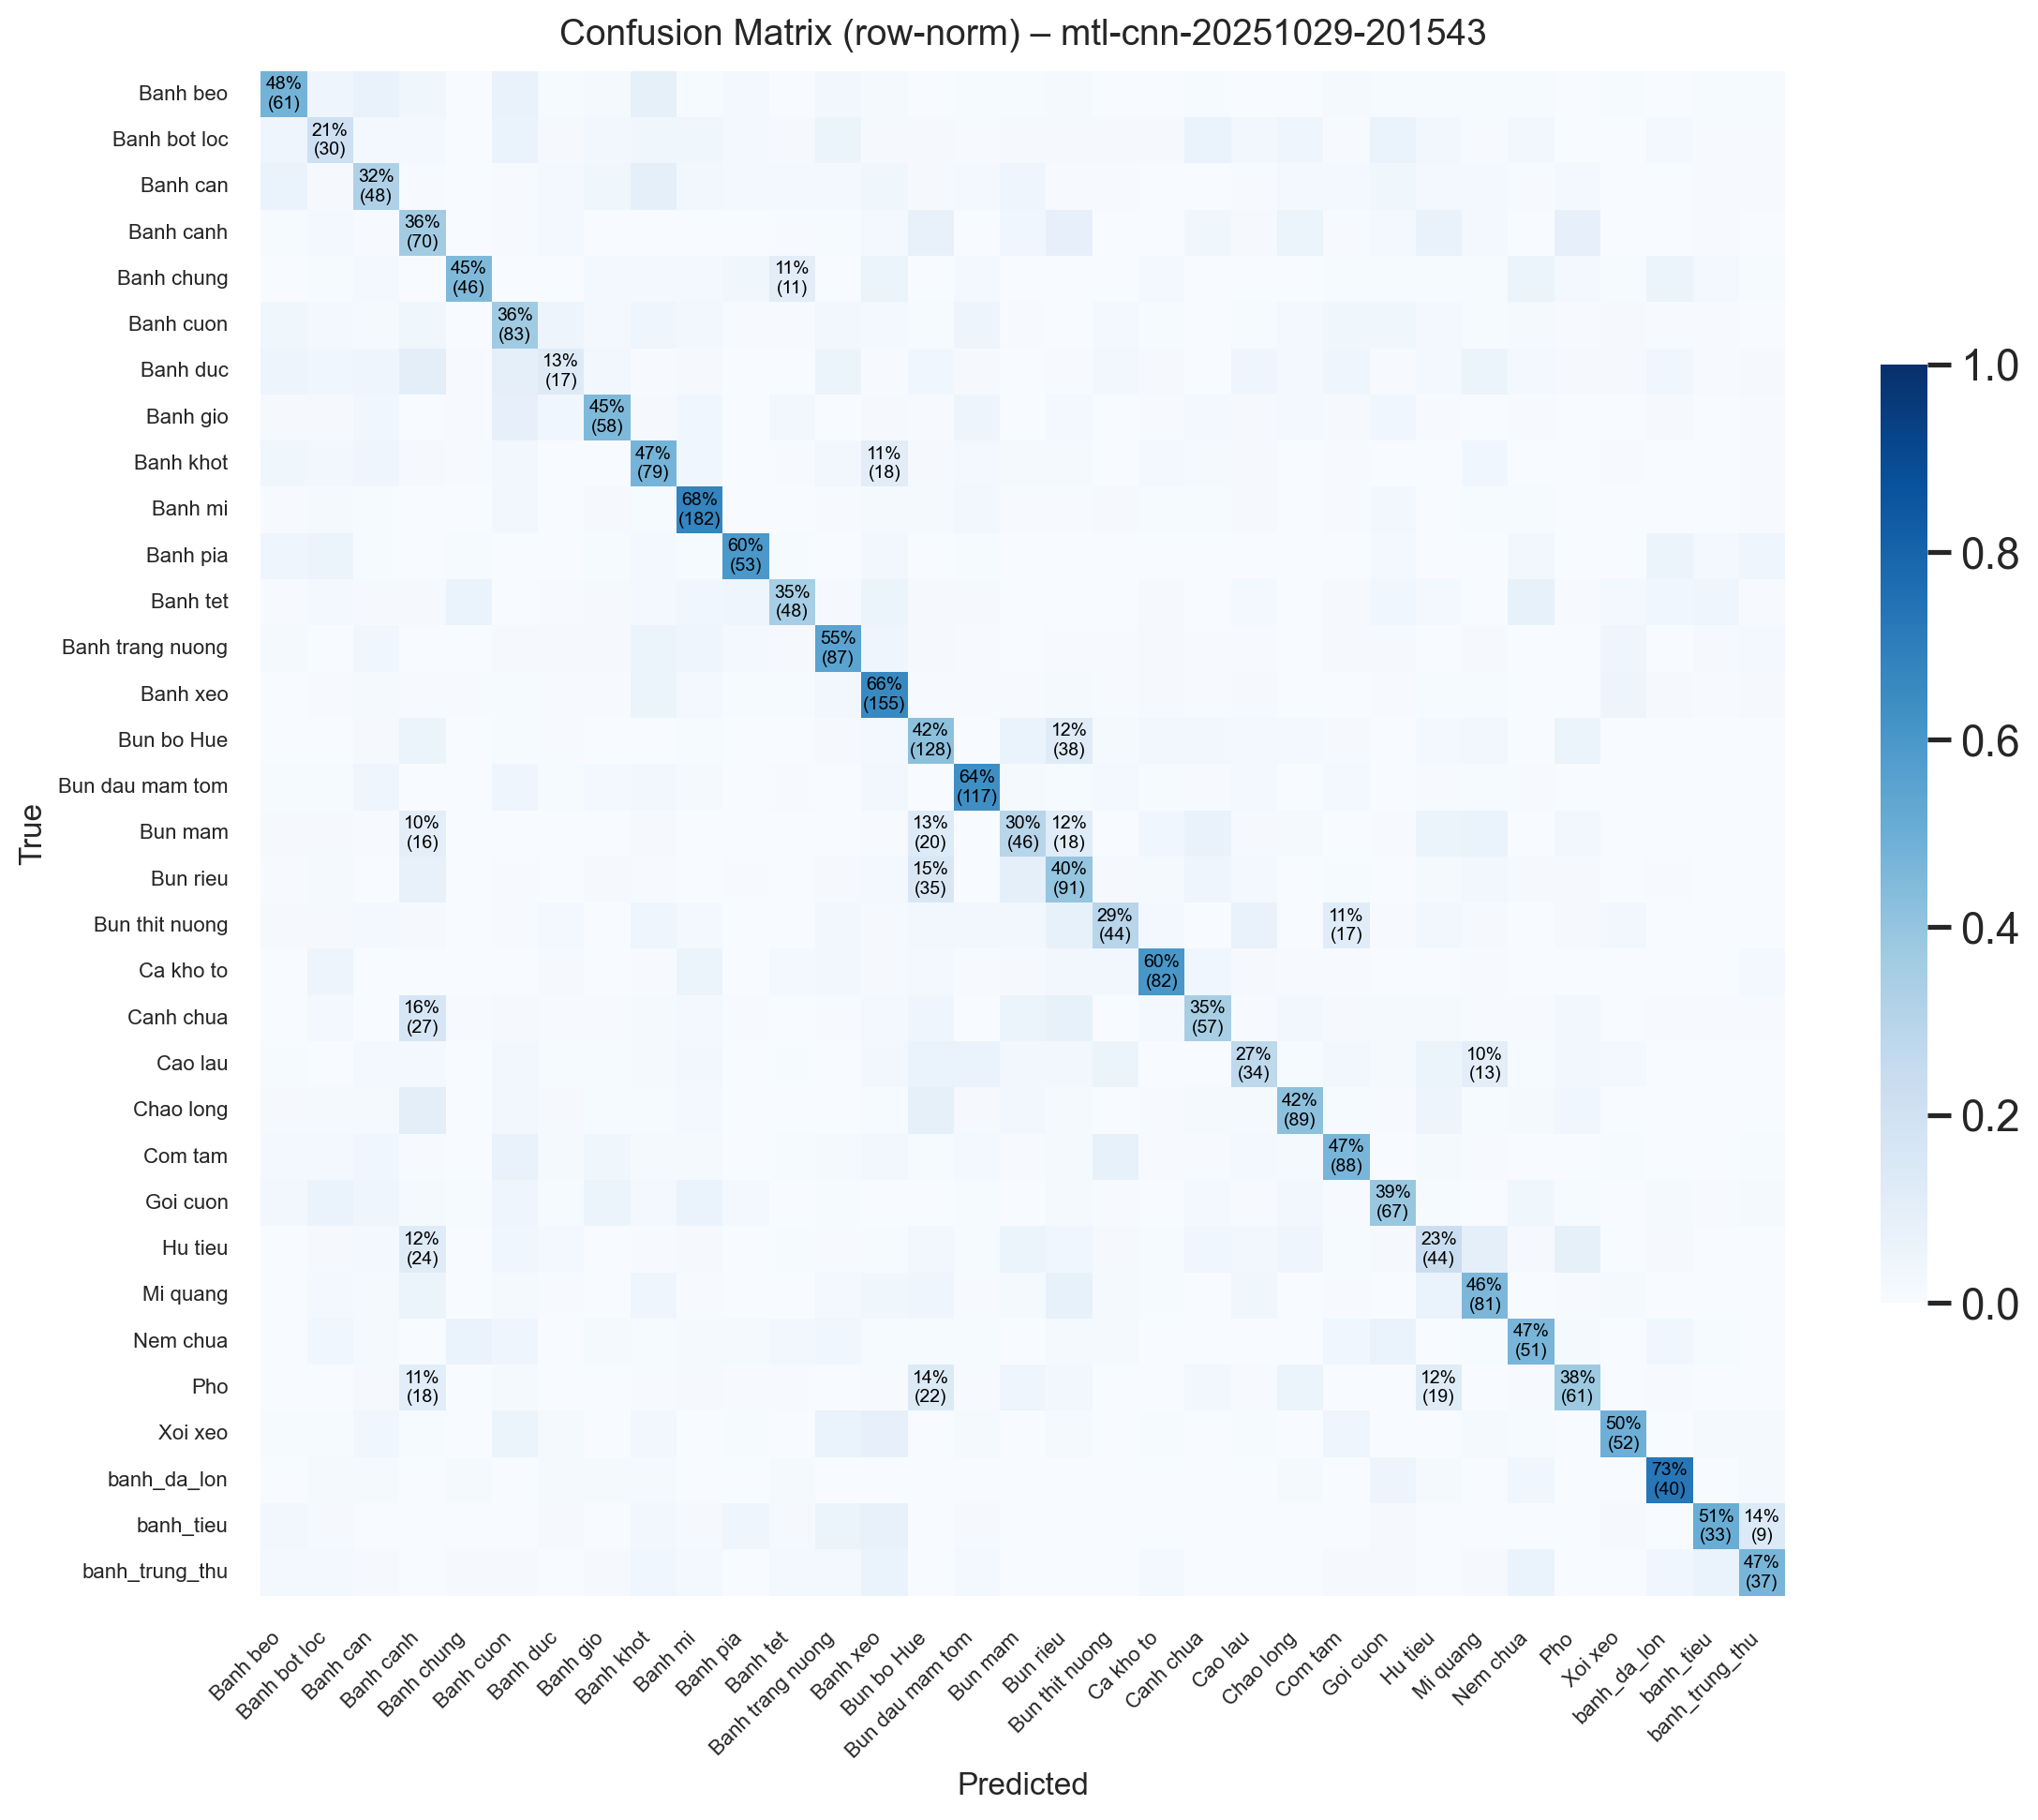

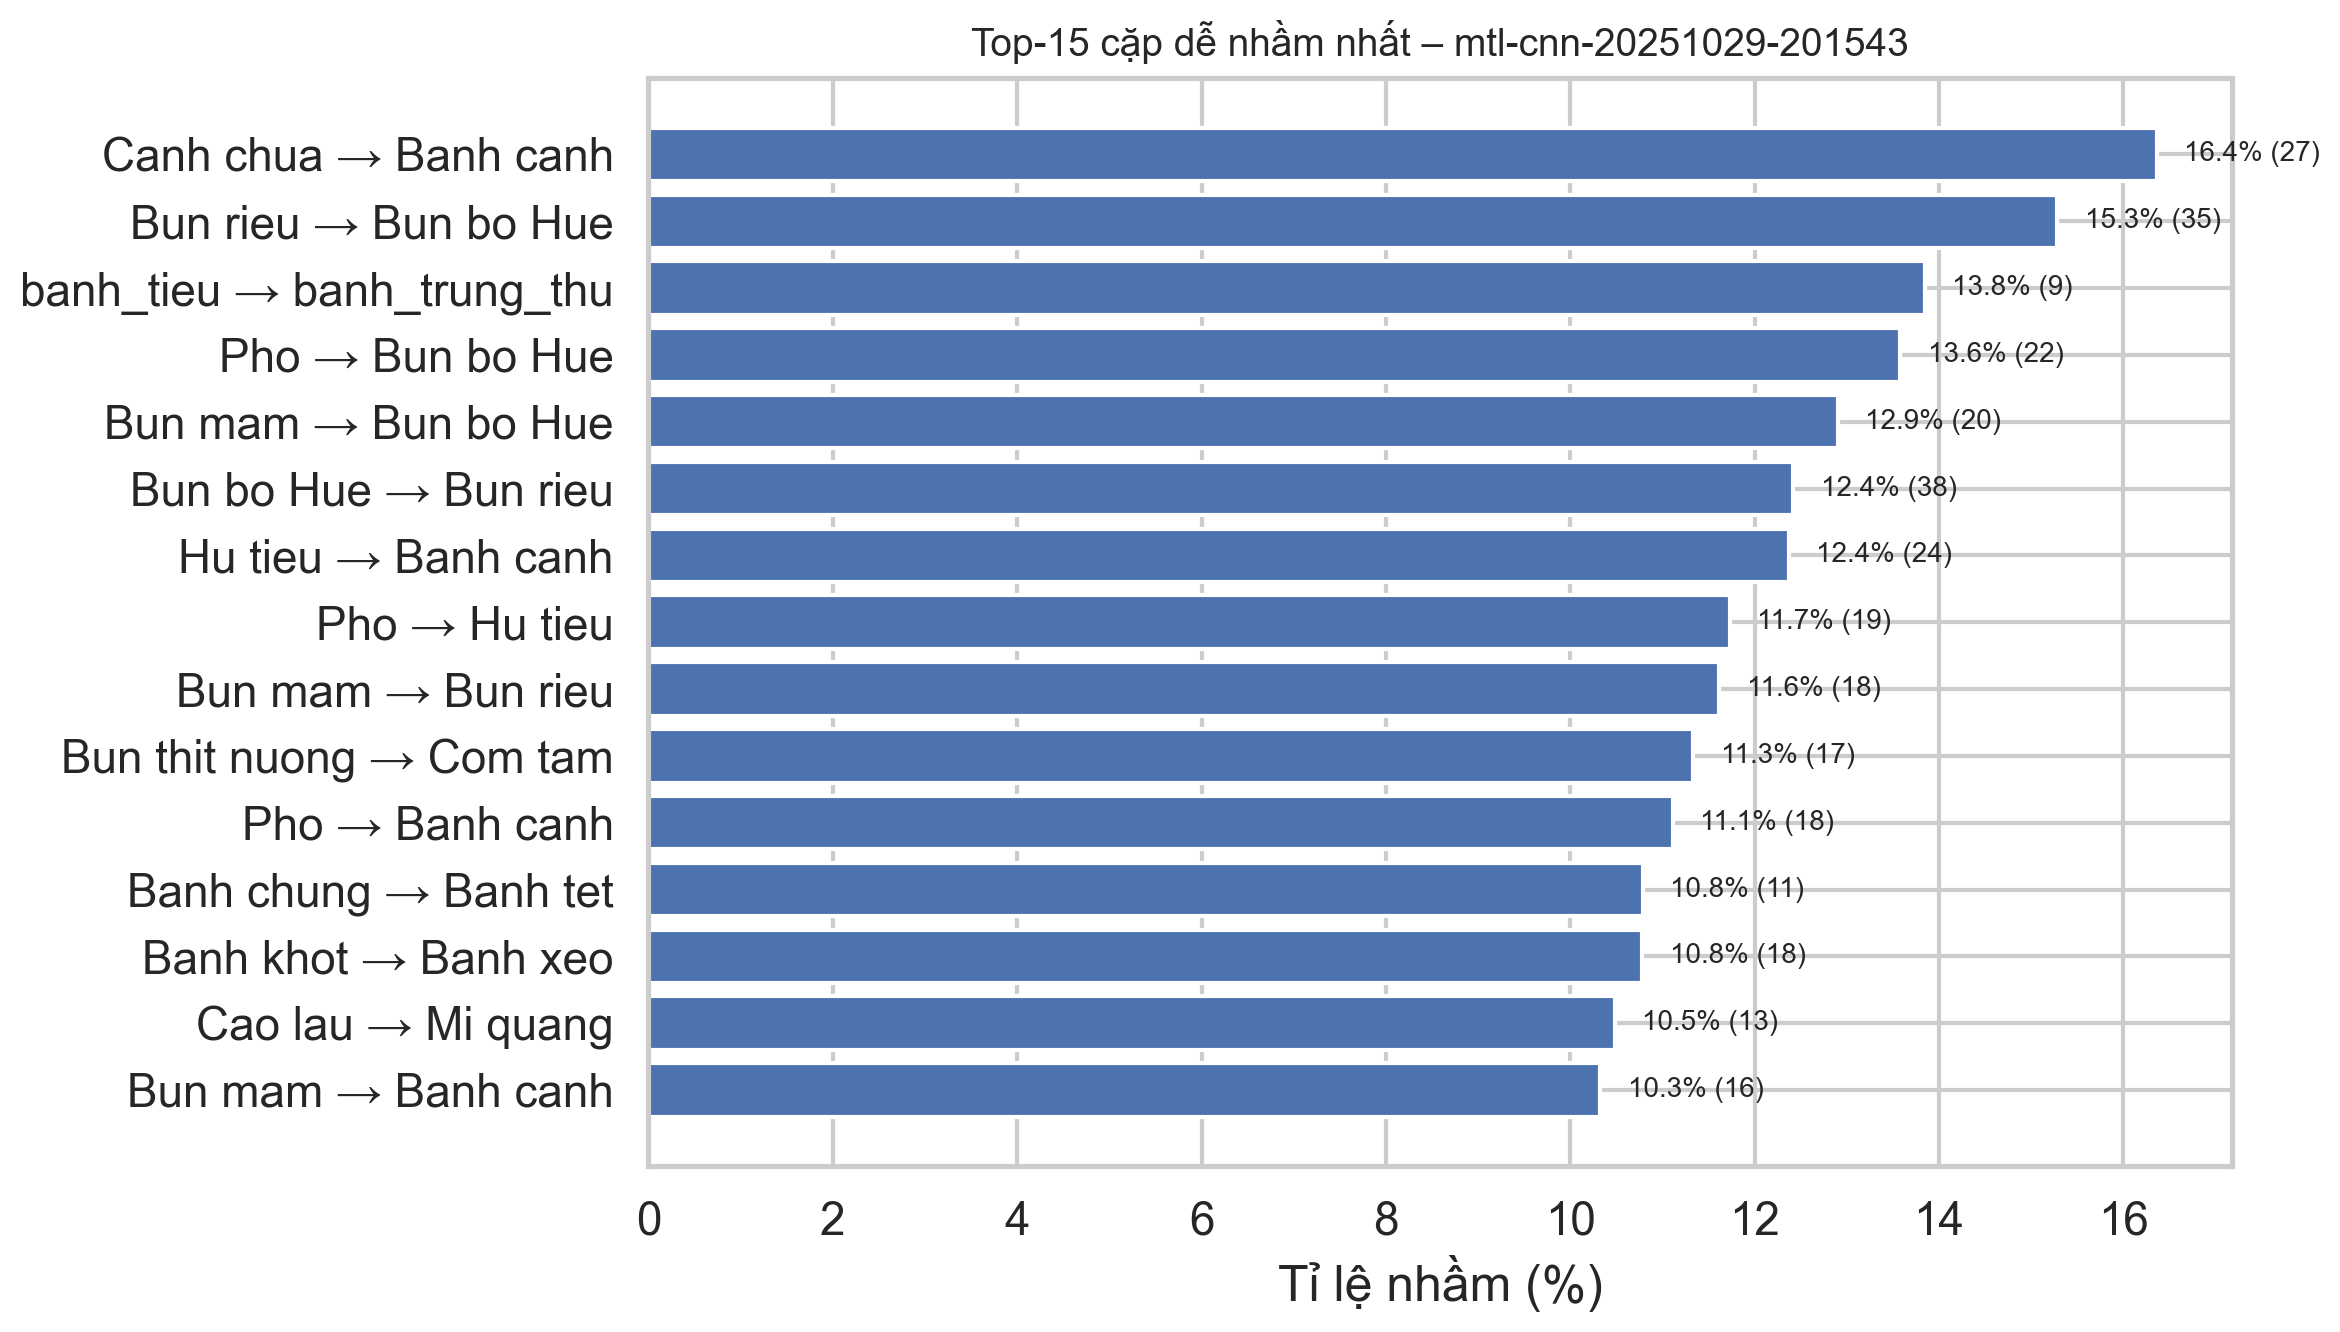


=== Đánh giá: mtl-mobilenetv4-20251029-223758 ===
  ✓ checkpoint: checkpoints\best.mtl


C:\Users\Admin\AppData\Local\Temp\ipykernel_31584\1403328210.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location=device)


  • Missing keys: 232 (chấp nhận nếu chỉ khác BN stats)
  • Unexpected keys: 278
   acc=0.0216  precision=0.0028  recall=0.0341  f1=0.0041


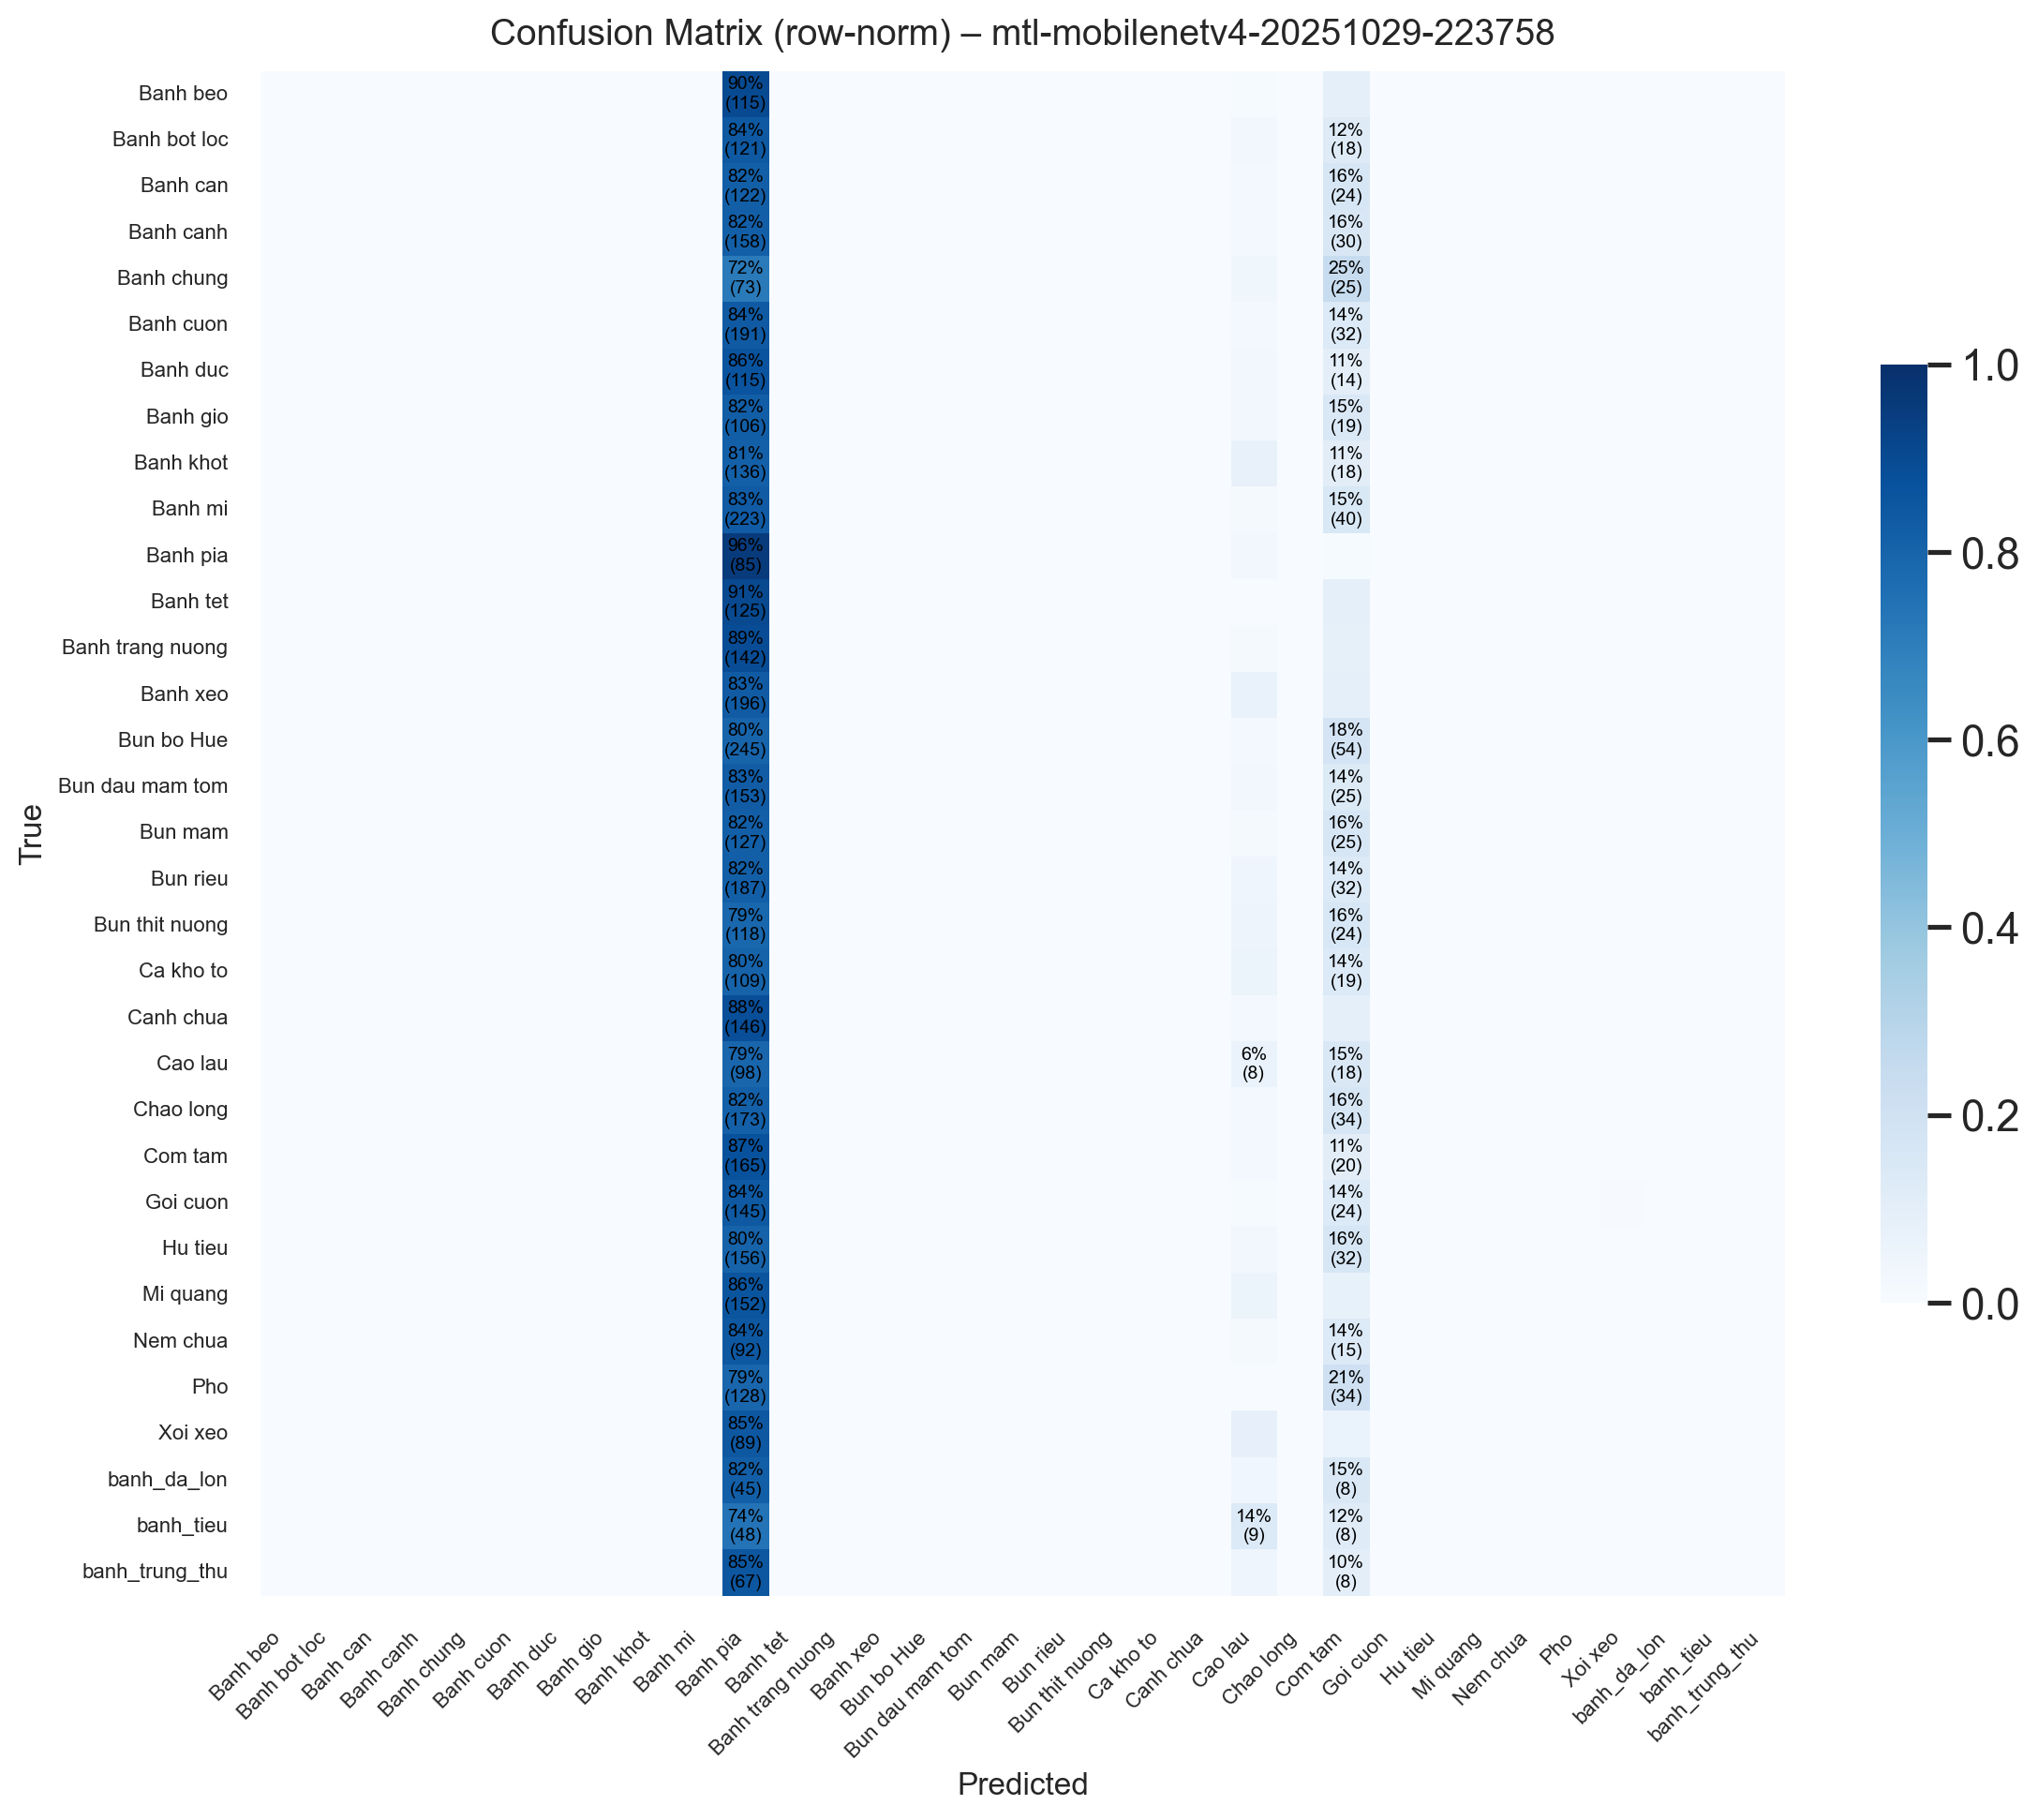

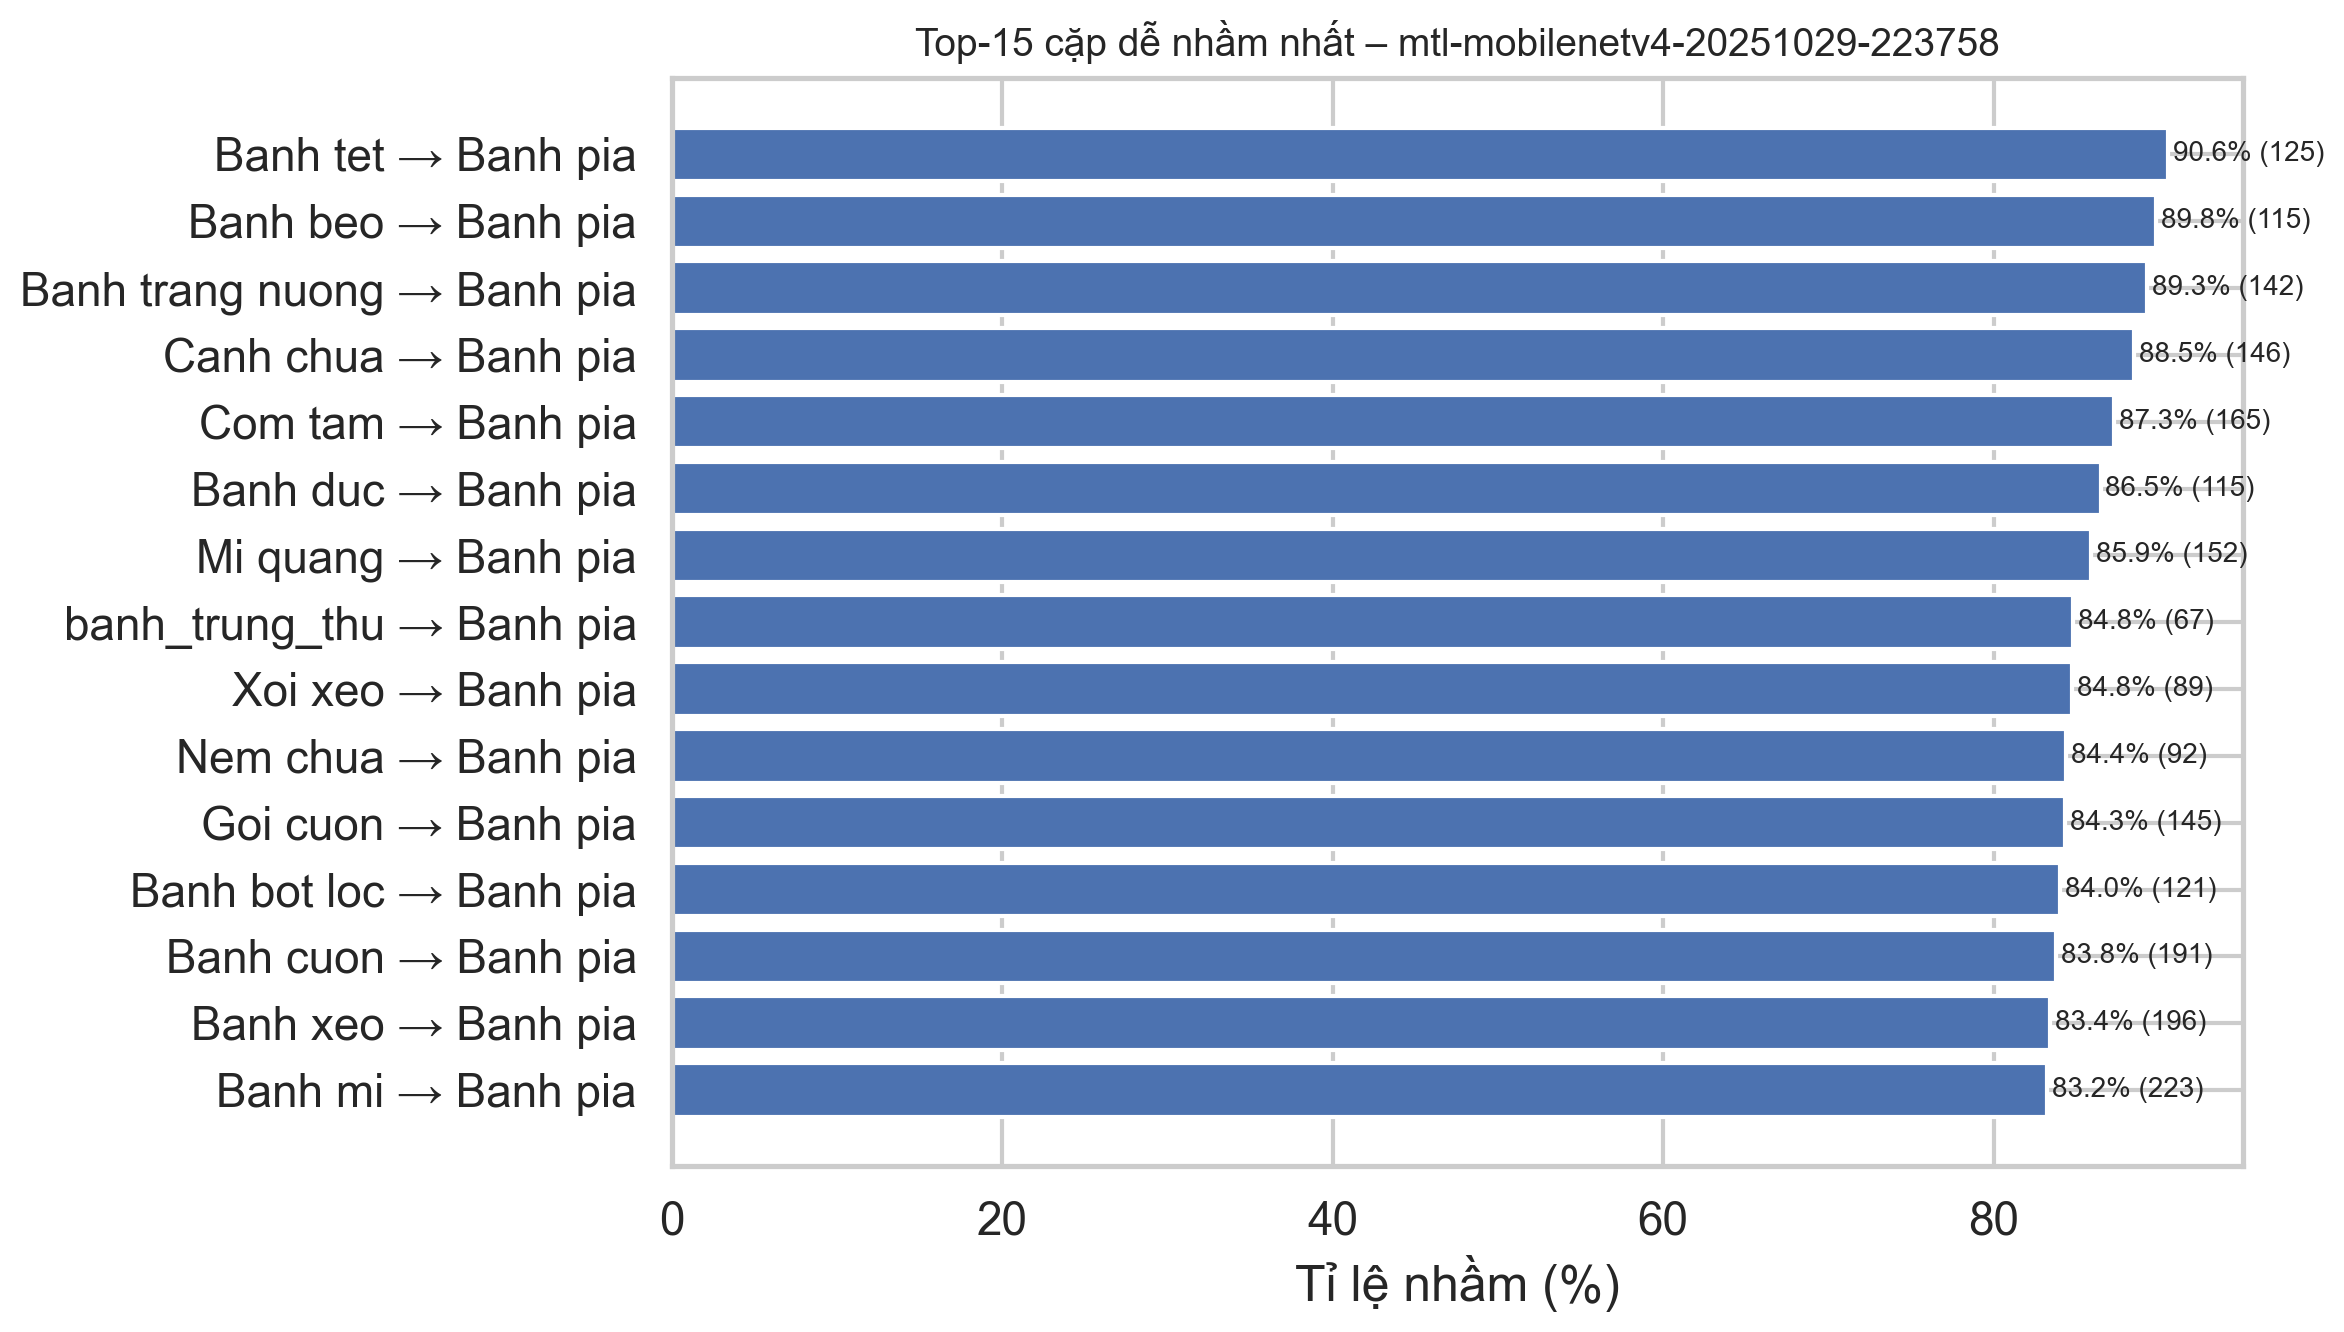

run       acc  precision    recall        f1  \
0          mtl-cnn-20251029-201543  0.431931   0.434166  0.434274  0.430418   
1  mtl-mobilenetv4-20251029-223758  0.021606   0.002807  0.034103  0.004122   

   n_images      ckpt  
0      5230  best.mtl  
1      5230  best.mtl

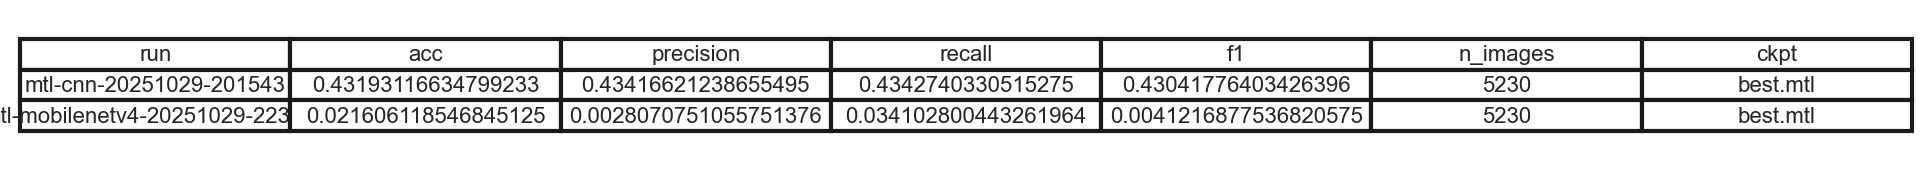

✅ Đã lưu: images/summary_models.png


In [88]:
# ==== CELL 6: EVALUATE ALL RUNS & RANKING ====
import os
import pandas as pd

results = []
if not os.path.isdir(RUNS_DIR):
    print(f"Thư mục {RUNS_DIR}/ không tồn tại.")
else:
    for run_name in sorted(os.listdir(RUNS_DIR)):
        run_path = os.path.join(RUNS_DIR, run_name)
        if not os.path.isdir(run_path): 
            continue
        # bỏ thư mục rác nếu có
        res = evaluate_model_at(run_path, run_name)
        if res: 
            results.append(res)

if results:
    df = pd.DataFrame(results).sort_values("acc", ascending=False)
    display(df)
    # Lưu bảng tổng hợp thành ảnh đơn giản (matplotlib table)
    try:
        fig, ax = plt.subplots(figsize=(10, 0.5 + 0.35*len(df)), dpi=200)
        ax.axis('off')
        tbl = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
        tbl.auto_set_font_size(False)
        tbl.set_fontsize(8)
        tbl.scale(1, 1.3)
        plt.tight_layout()
        plt.savefig("images/summary_models.png", dpi=300, bbox_inches="tight")
        plt.show()
        print("✅ Đã lưu: images/summary_models.png")
    except Exception as e:
        print("Không thể render bảng ra ảnh:", e)
else:
    print("Không có mô hình hợp lệ trong thư mục Runs/")


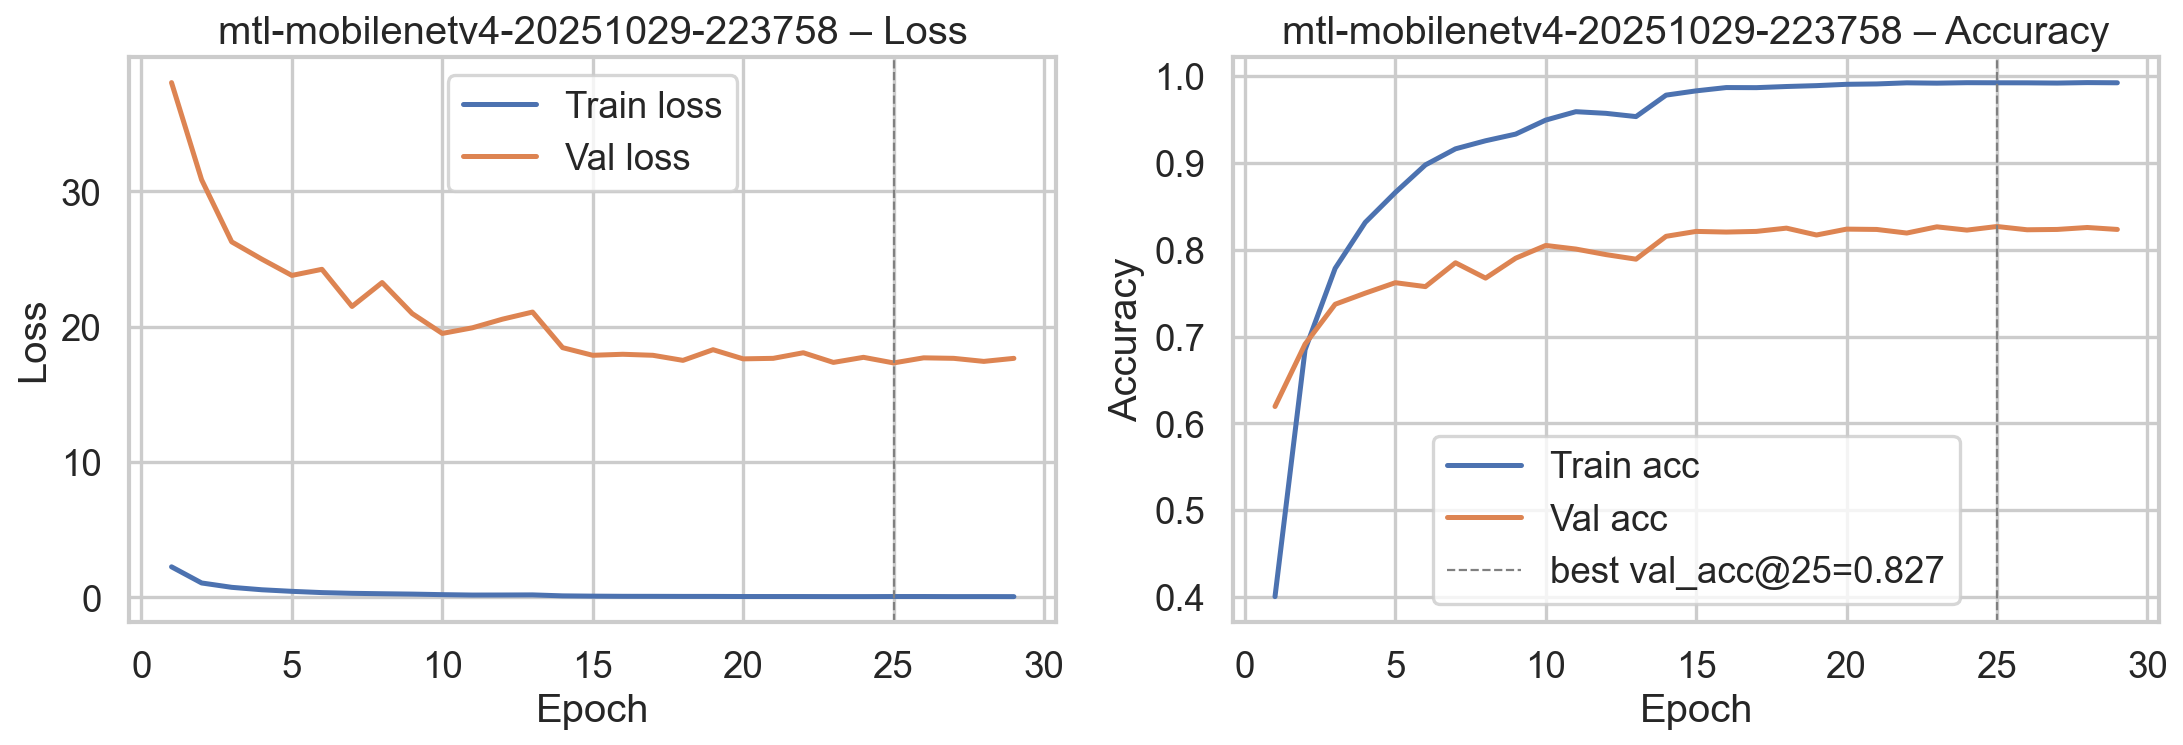

✓ Đã lưu: images/mtl-mobilenetv4-20251029-223758_history.png


In [89]:
# ==== CELL 7 (REPLACE): Vẽ Loss/Accuracy theo đúng số epoch của TỪNG mô hình ====
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

def pick_col(df, pats):
    """Chọn cột đầu tiên khớp các pattern (không phân biệt hoa thường)."""
    pats = [p.lower() for p in pats]
    for c in df.columns:
        cl = c.lower()
        if any(re.search(p, cl) for p in pats):
            return c
    return None

def plot_history_for_run(run_path, run_name):
    # tìm file log
    candidates = ["history.csv", "history.json", "train_log.csv", "metrics.csv"]
    hist_path = None
    for f in candidates:
        p = os.path.join(run_path, f)
        if os.path.isfile(p):
            hist_path = p
            break
    if hist_path is None:
        print(f"[{run_name}] Không tìm thấy history.csv|json|log")
        return

    # đọc & chuẩn hoá tên cột
    if hist_path.endswith(".json"):
        df = pd.read_json(hist_path)
    else:
        df = pd.read_csv(hist_path)
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]  # giữ nguyên chữ nhưng loại khoảng trắng

    # Xác định epoch theo dữ liệu file này
    c_epoch = pick_col(df, [r"^epoch$", r"^epochs?$"])
    if c_epoch is not None:
        epoch = df[c_epoch].to_numpy()
    else:
        epoch = np.arange(1, len(df) + 1)

    # Bắt cột loss/acc (dùng pattern mềm)
    c_train_loss = pick_col(df, [r"^loss$", r"train.*loss"])
    c_val_loss   = pick_col(df, [r"val.*loss", r"valid.*loss"])
    c_train_acc  = pick_col(df, [r"^acc$", r"accuracy$", r"train.*acc", r"train.*accuracy"])
    c_val_acc    = pick_col(df, [r"val.*acc", r"val.*accuracy", r"valid.*acc", r"valid.*accuracy"])

    # Lấy series (có thể None)
    tr_loss = df[c_train_loss].to_numpy() if c_train_loss else None
    va_loss = df[c_val_loss].to_numpy()   if c_val_loss   else None
    tr_acc  = df[c_train_acc].to_numpy()  if c_train_acc  else None
    va_acc  = df[c_val_acc].to_numpy()    if c_val_acc    else None

    # Tìm epoch tốt nhất để chú thích
    best_ep = None
    note = ""
    if va_acc is not None:
        best_ep = int(epoch[np.nanargmax(va_acc)])
        note = f"best val_acc@{best_ep}={np.nanmax(va_acc):.3f}"
    elif va_loss is not None:
        best_ep = int(epoch[np.nanargmin(va_loss)])
        note = f"best val_loss@{best_ep}={np.nanmin(va_loss):.3f}"

    # Vẽ
    fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=160)
    # Loss
    if tr_loss is not None: ax[0].plot(epoch, tr_loss, label="Train loss")
    if va_loss is not None: ax[0].plot(epoch, va_loss, label="Val loss")
    if best_ep is not None: ax[0].axvline(best_ep, ls="--", lw=1, c="gray")
    ax[0].set_title(f"{run_name} – Loss")
    ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss"); ax[0].legend()

    # Accuracy
    if tr_acc is not None: ax[1].plot(epoch, tr_acc, label="Train acc")
    if va_acc is not None: ax[1].plot(epoch, va_acc, label="Val acc")
    if best_ep is not None: ax[1].axvline(best_ep, ls="--", lw=1, c="gray", label=note if va_acc is not None else None)
    ax[1].set_title(f"{run_name} – Accuracy")
    ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy"); ax[1].legend()

    plt.tight_layout()
    out_png = f"images/{run_name}_history.png"
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Đã lưu:", out_png)

# Gọi cho TỪNG run khi bạn đang ở vòng lặp evaluate
# (nếu bạn đã có biến run_path, run_name trong Cell 6, chỉ việc gọi)
plot_history_for_run(run_path, run_name)


In [90]:
# ==== CELL 8A: (Optional) Thu thập y_true, y_pred, y_prob từ model ====
import torch, numpy as np

def collect_logits_with_index(model, loader, device):
    model.eval()
    y_true, y_pred, y_prob, idxs = [], [], [], []
    cursor = 0
    with torch.no_grad():
        for x, y in loader:
            n = x.size(0)
            x = x.to(device)
            logits = model(x)
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            pred = prob.argmax(axis=1)
            y_true.append(y.numpy())
            y_pred.append(pred)
            y_prob.append(prob)
            idxs.extend(range(cursor, cursor+n))
            cursor += n
    return (np.concatenate(y_true), 
            np.concatenate(y_pred), 
            np.concatenate(y_prob), 
            np.array(idxs))

if "y_prob" not in globals() or y_prob is None:
    y_true, y_pred, y_prob, sample_indices = collect_logits_with_index(model, test_loader, device)
    print("Shapes:", y_true.shape, y_pred.shape, y_prob.shape, sample_indices.shape)
else:
    # nếu trước đó đã có sample_indices, giữ nguyên; nếu chưa, suy ra theo thứ tự batch
    if "sample_indices" not in globals():
        sample_indices = np.arange(len(y_true))


AUC micro: 0.510 | AUC macro: 0.500


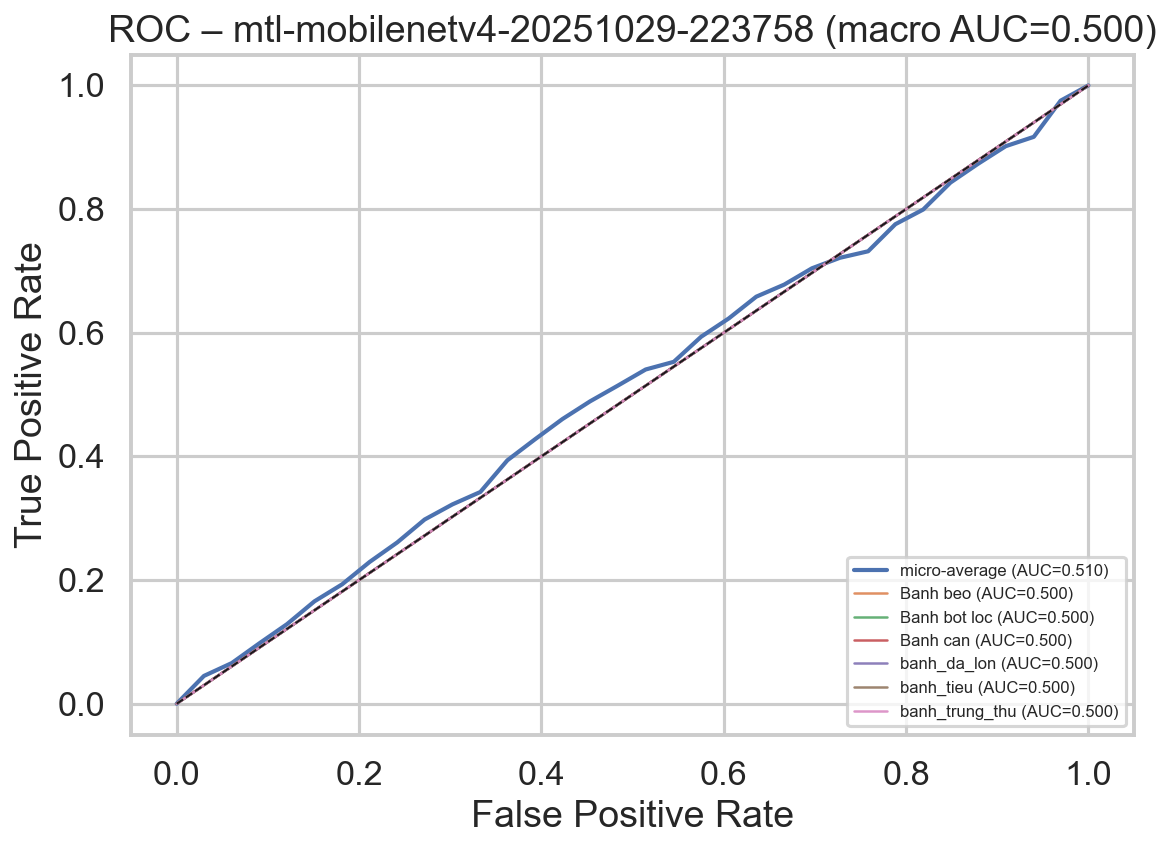

✓ Đã lưu: images/mtl-mobilenetv4-20251029-223758_roc.png


In [91]:
# ==== CELL 8B: ROC Curves (multi-class, one-vs-rest) ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

os.makedirs("images", exist_ok=True)

Y = label_binarize(y_true, classes=range(len(class_names)))  # (N, C) 0/1
# đảm bảo y_prob đã chuẩn hóa softmax (từ Cell 8A)
assert y_prob.shape == Y.shape

# AUC per-class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(Y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro/macro
fpr["micro"], tpr["micro"], _ = roc_curve(Y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc_macro = np.mean(list(roc_auc.values()))
print(f"AUC micro: {roc_auc['micro']:.3f} | AUC macro: {roc_auc_macro:.3f}")

# Vẽ
fig, ax = plt.subplots(figsize=(8,6), dpi=150)
ax.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})", lw=2)

# vẽ 3 lớp tốt và 3 lớp kém nhất để hình không rối
sorted_cls = sorted(range(len(class_names)), key=lambda i: roc_auc[i], reverse=True)
for i in sorted_cls[:3] + sorted_cls[-3:]:
    ax.plot(fpr[i], tpr[i], lw=1.2, alpha=0.9, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")

ax.plot([0,1],[0,1],"k--", lw=1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title(f"ROC – {run_name} (macro AUC={roc_auc_macro:.3f})")
ax.legend(loc="lower right", fontsize=8)
plt.tight_layout()
out_png = f"images/{run_name}_roc.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print("✓ Đã lưu:", out_png)


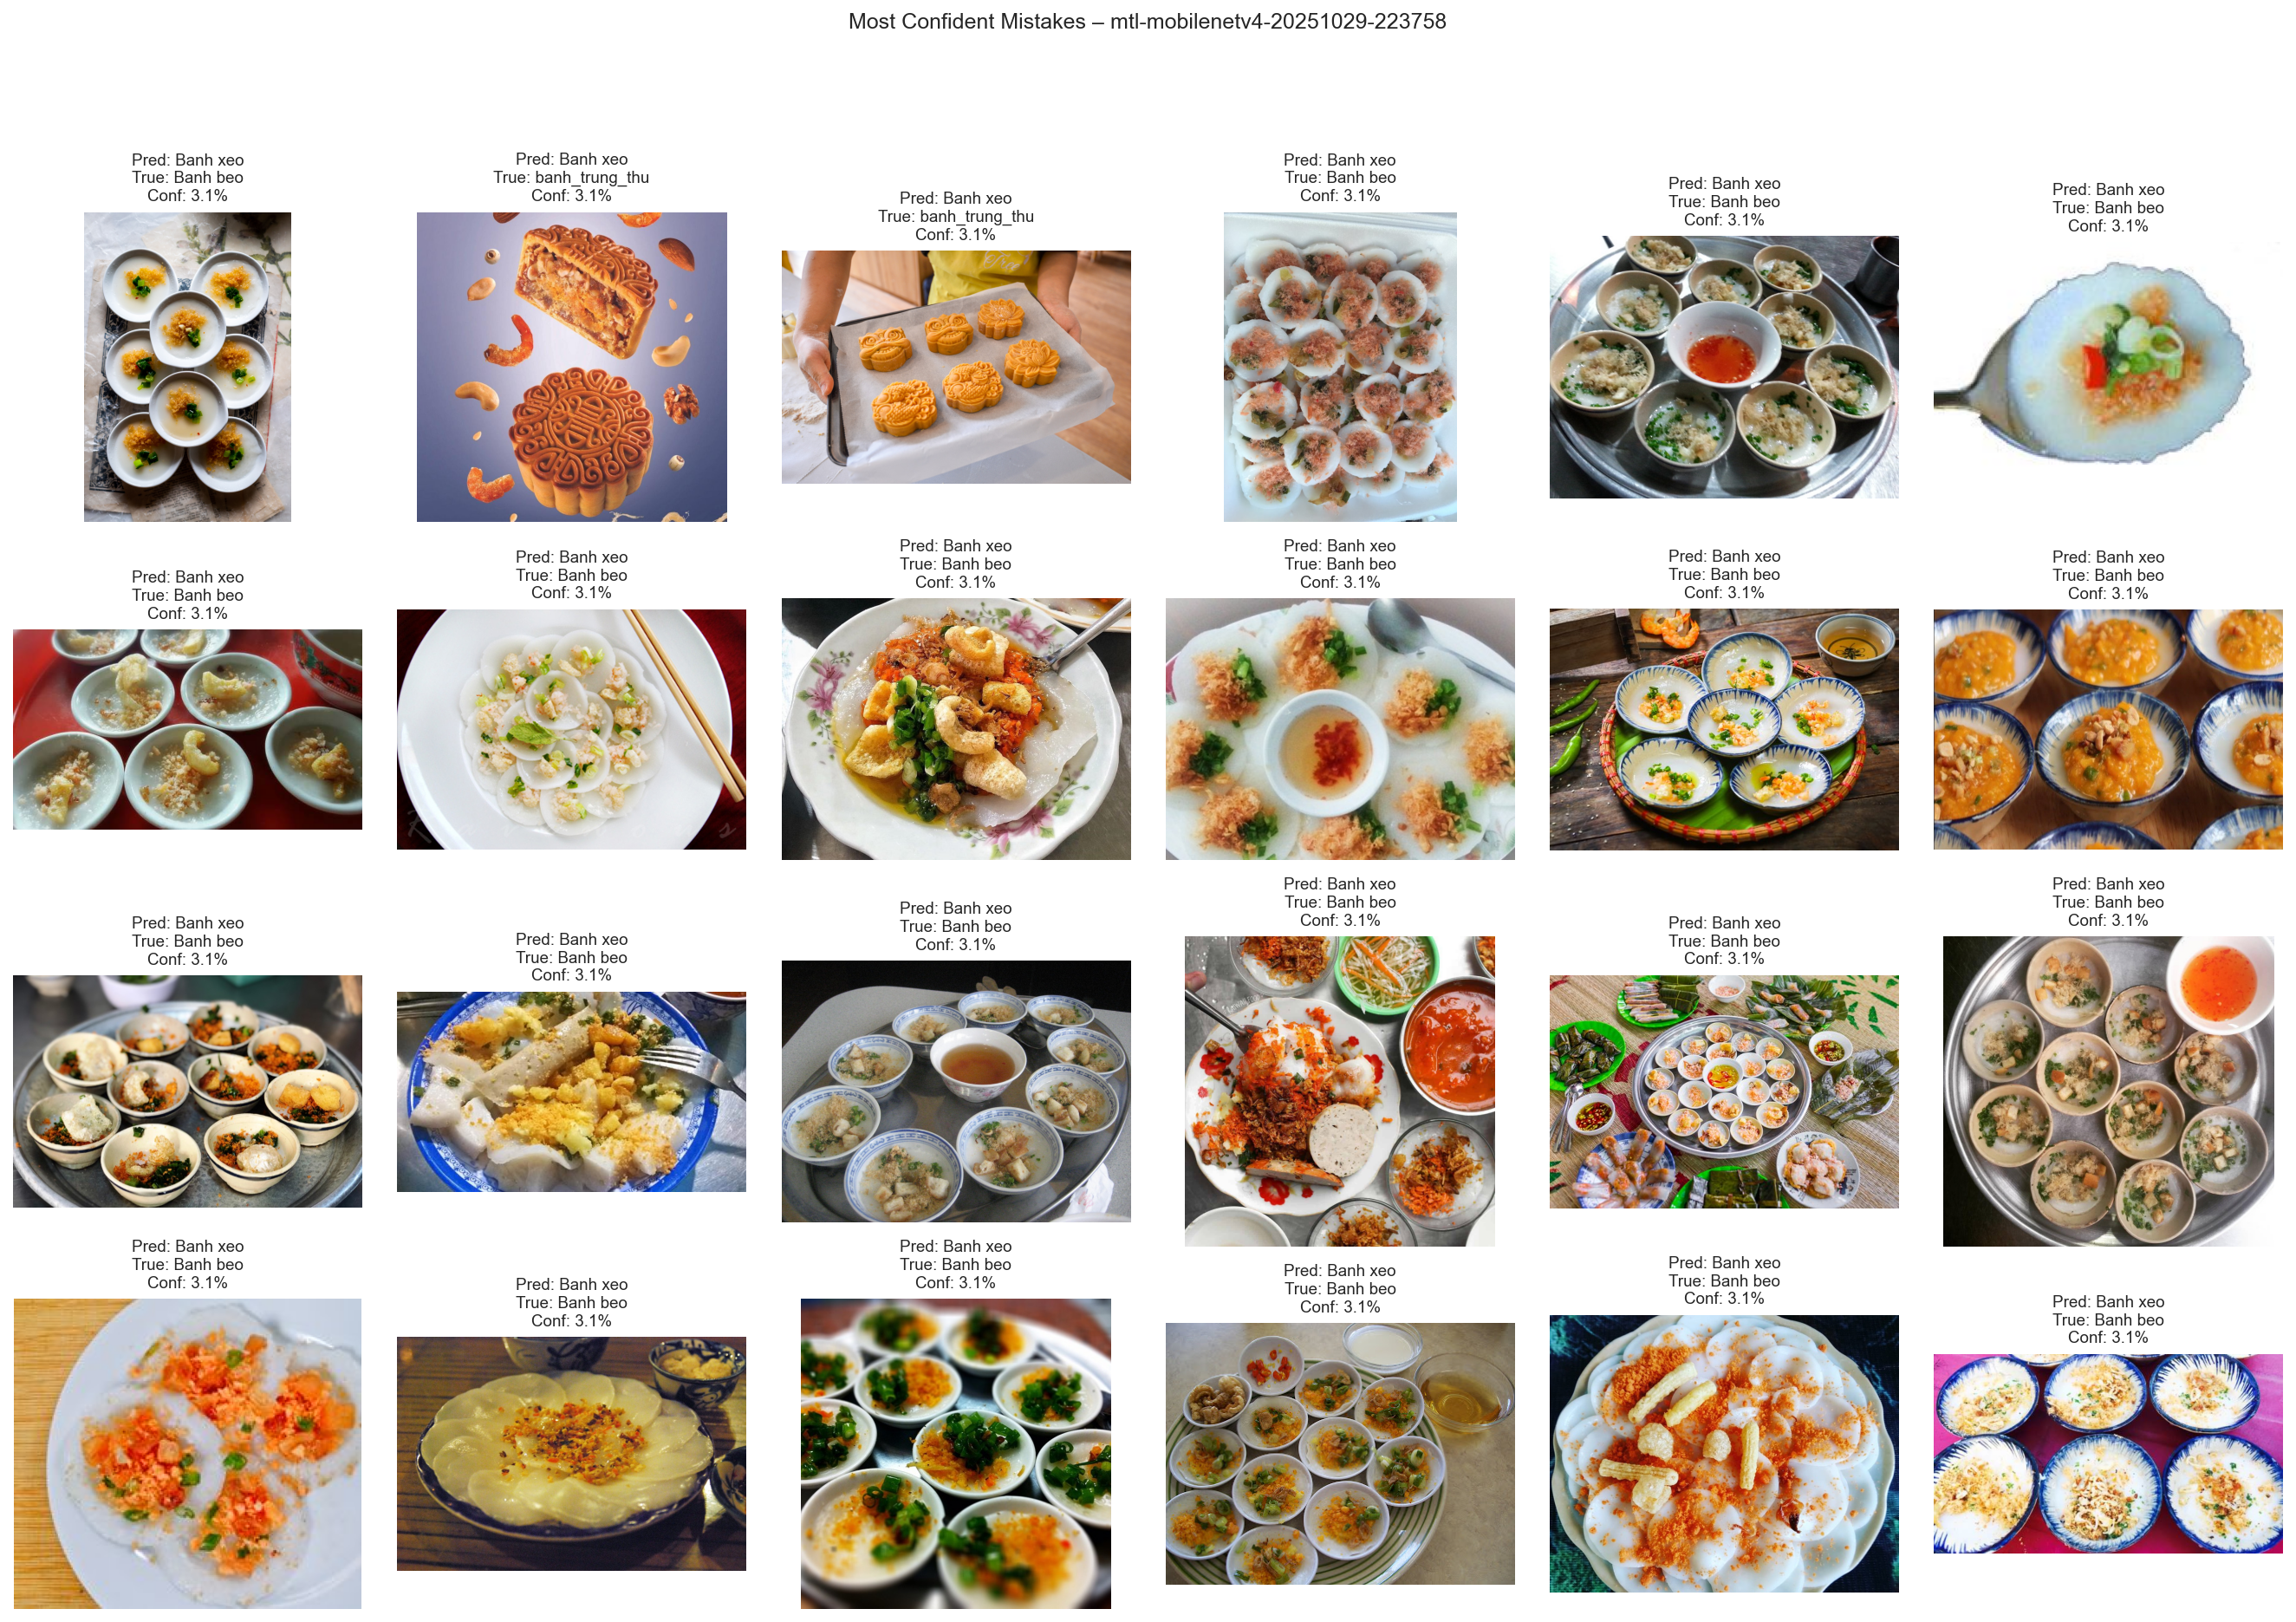

✓ Đã lưu: images/mtl-mobilenetv4-20251029-223758_mistakes.png


In [92]:
# ==== CELL 9: Error Analysis – show most confident wrong predictions ====
import os, math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Lấy đường dẫn ảnh theo thứ tự dataset
ds = test_loader.dataset
if hasattr(ds, "samples"):
    paths = [p for p,_ in ds.samples]
elif hasattr(ds, "imgs"):
    paths = [p for p,_ in ds.imgs]
else:
    paths = None

assert paths is not None, "Dataset cần có .samples hoặc .imgs để truy vết file ảnh."

# Xác định các dự đoán sai và độ tự tin của mô hình ở lớp dự đoán
conf_pred = y_prob[np.arange(len(y_pred)), y_pred]
wrong_idx = np.where(y_pred != y_true)[0]
# Top-k sai nhưng tự tin cao nhất
topk = 24
sel = wrong_idx[np.argsort(conf_pred[wrong_idx])[::-1][:topk]]

ncols = 6
nrows = math.ceil(len(sel)/ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3.2*nrows), dpi=150)
axes = np.array(axes).reshape(nrows, ncols)

for k, ax in enumerate(axes.ravel()):
    if k >= len(sel):
        ax.axis("off"); continue
    i = sel[k]
    img = Image.open(paths[i]).convert("RGB")
    ax.imshow(img)
    true, pred = class_names[y_true[i]], class_names[y_pred[i]]
    p = conf_pred[i]*100
    ax.set_title(f"Pred: {pred}\nTrue: {true}\nConf: {p:.1f}%", fontsize=9)
    ax.axis("off")

plt.suptitle(f"Most Confident Mistakes – {run_name}", fontsize=12)
plt.tight_layout(rect=[0,0,1,0.95])
out_png = f"images/{run_name}_mistakes.png"
plt.savefig(out_png, dpi=300, bbox_inches="tight")
plt.show()
print("✓ Đã lưu:", out_png)


In [93]:
# ==== CELL 10: Speed & Resources benchmark ====
import time, torch, numpy as np

def model_num_params_and_size(model):
    n_params = sum(p.numel() for p in model.parameters())
    n_buffers = sum(b.numel() for b in model.buffers())
    total_elems = n_params + n_buffers
    # size bytes = elems * element_size (giả định FP32 nếu không mixed)
    bytes_ = 0
    with torch.no_grad():
        for t in list(model.parameters()) + list(model.buffers()):
            bytes_ += t.numel() * t.element_size()
    return n_params, bytes_

def benchmark(model, device, input_size=(1,3,224,224), warmup=10, runs=50):
    model.eval()
    x = torch.randn(*input_size, device=device)
    with torch.no_grad():
        # warmup
        for _ in range(warmup):
            _ = model(x)
            if device.type == "cuda": torch.cuda.synchronize()
        # measure
        times = []
        for _ in range(runs):
            t0 = time.perf_counter()
            _ = model(x)
            if device.type == "cuda": torch.cuda.synchronize()
            t1 = time.perf_counter()
            times.append((t1 - t0)*1000.0)  # ms
    times = np.array(times)
    ms_avg = times.mean()
    ms_p50 = np.percentile(times, 50)
    ms_p95 = np.percentile(times, 95)
    batch = input_size[0]
    fps = batch * 1000.0 / ms_avg
    return {
        "latency_ms_avg": ms_avg,
        "latency_ms_p50": ms_p50,
        "latency_ms_p95": ms_p95,
        "fps": fps
    }

# chạy benchmark
n_params, size_bytes = model_num_params_and_size(model)
bench = benchmark(model, device, input_size=(1,3,224,224))

# in & lưu
size_mb = size_bytes / (1024**2)
print(f"[{run_name}] Params: {n_params:,} | Size: {size_mb:.2f} MB")
print(f"[{run_name}] Latency avg: {bench['latency_ms_avg']:.2f} ms | p50: {bench['latency_ms_p50']:.2f} | p95: {bench['latency_ms_p95']:.2f} | FPS: {bench['fps']:.1f}")

import json, os
os.makedirs("images", exist_ok=True)
with open(f"images/{run_name}_speed.json", "w", encoding="utf-8") as f:
    json.dump({
        "run": run_name,
        "params": int(n_params),
        "size_mb": float(f"{size_mb:.4f}"),
        "latency_ms_avg": float(f"{bench['latency_ms_avg']:.3f}"),
        "latency_ms_p50": float(f"{bench['latency_ms_p50']:.3f}"),
        "latency_ms_p95": float(f"{bench['latency_ms_p95']:.3f}"),
        "fps": float(f"{bench['fps']:.2f}")
    }, f, ensure_ascii=False, indent=2)
print("✓ Đã lưu: ", f"images/{run_name}_speed.json")


[mtl-mobilenetv4-20251029-223758] Params: 3,240,801 | Size: 12.45 MB
[mtl-mobilenetv4-20251029-223758] Latency avg: 4.90 ms | p50: 3.51 | p95: 12.97 | FPS: 203.9
✓ Đã lưu:  images/mtl-mobilenetv4-20251029-223758_speed.json
